# Host-Phage Biomass Optima

In this notebook, we examine the tradeoffs between the host and phage biomass production.

We are focused on the effects of nutrient uptake and its interplay with AMG expression. Because the gene phoH directly impacts P uptake, its effect is considered separately through an "excess" or "extreme" P uptake rate.

In [5]:
import json
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from cobra.flux_analysis.variability import flux_variability_analysis as fva

cobra.Configuration.solver = "glpk"

In [65]:
model = cobra.io.read_sbml_model("model_files/ProchlorococcusMED4+PHM2v1.xml")

In [22]:
amgs = json.loads(open("model_files/amg_reactions.json").read())
scenarios = [
    "Unconstrained Uptake",
    "Excess P uptake",
    "Extreme P uptake",
    "Mild N limit",
    "Mild P limit",
    "Moderate N limit",
    "Moderate P limit",
    "Severe N limit",
    "Severe P limit",
]

scenario_colors = {
    "Unconstrained Uptake": "black",
    "Excess P uptake": "#ff99ff",
    "Extreme P uptake": "#ff00ff",
    "Mild N limit": "#5555cc",
    "Mild P limit": "#995522",
    "Moderate N limit": "#55aa55",
    "Moderate P limit": "#ff8855",
    "Severe N limit": "#aa1177",
    "Severe P limit": "#ff4444",
}

In [7]:
host_optimum = model.slim_optimize()
host_optimum

0.09846248800237382

In [8]:
with model as host_model:
    h_fva = fva(
        host_model,
        [host_model.reactions.AmmoniaEX, host_model.reactions.FAKEOrthophosphateEX],
    )
with model as phage_model:
    phage_model.objective = phage_model.reactions.PHM2_prodrxn_VN.flux_expression
    p_fva = fva(
        phage_model,
        [phage_model.reactions.AmmoniaEX, phage_model.reactions.FAKEOrthophosphateEX],
    )

print("Host-optimal")
print(h_fva)
print()
print("Phage-optimal")
print(p_fva)

Host-optimal
                       minimum   maximum
AmmoniaEX            -0.864117 -0.855149
FAKEOrthophosphateEX -0.033099 -0.033099

Phage-optimal
                       minimum   maximum
AmmoniaEX            -1.637692 -1.637692
FAKEOrthophosphateEX -0.187383 -0.187383


In [10]:
N_LIMIT_VALS = [-0.86 * 1.5, -0.86 * 0.9, -0.86 * 0.2]
P_LIMIT_VALS = [-0.033 * 1.5, -0.033 * 0.9, -0.033 * 0.2]

In [137]:
def set_nutrient_limits(model, scenario):
    if scenario == "Mild N limit":
        model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[0], 0
    elif scenario == "Mild P limit":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            P_LIMIT_VALS[0],
            0,
        )
    elif scenario == "Moderate N limit":
        model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[1], 0
    elif scenario == "Moderate P limit":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            P_LIMIT_VALS[1],
            0,
        )
    elif scenario == "Severe N limit":
        model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[2], 0
    elif scenario == "Severe P limit":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            P_LIMIT_VALS[2],
            0,
        )
    elif scenario == "Excess P uptake":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            2 * P_LIMIT_VALS[0],  # approx 3x host-optimal
            2 * P_LIMIT_VALS[0],
        )
    elif scenario == "Extreme P uptake":
        model.reactions.FAKEOrthophosphateEX.bounds = (
            20 * P_LIMIT_VALS[0],  # approx 30x host-optimal
            20 * P_LIMIT_VALS[0],
        )


def set_amg_limits(model, amg, direction, tol=0.1):
    if direction == "raw increase":
        model.objective = model.reactions.get_by_id(amg).flux_expression
        obj = model.slim_optimize()
        if obj >= 0:
            model.reactions.get_by_id(amg).bounds = (
                obj * (1 - tol),
                obj * (1 + tol),
            )
        else:
            model.reactions.get_by_id(amg).bounds = obj, 0
    elif direction == "absolute increase":
        model.objective = (
            model.reactions.get_by_id(amg).forward_variable
            + model.reactions.get_by_id(amg).reverse_variable
        )
        obj = model.slim_optimize()
        model.reactions.get_by_id(amg).bounds = (
            -abs(obj) * (1 + tol),
            abs(obj) * (1 + tol),
        )
    elif direction == "absolute decrease":
        model.objective = (
            -model.reactions.get_by_id(amg).forward_variable
            - model.reactions.get_by_id(amg).reverse_variable
        )
        obj = model.slim_optimize()
        model.reactions.get_by_id(amg).bounds = (
            -abs(obj) * (1 + tol),
            abs(obj) * (1 + tol),
        )


# def set_amg_limits(model, amg, direction, tol=0.1):
#     # note that we use min/max functions to avoid errors due to floating point precision
#     print("-" * 10, model.reactions.BIOMASS.bounds)
#     if direction == "raw increase" or direction == "absolute increase":
#         permissive_fva = fva(model, [model.reactions.get_by_id(amg)])
#         lb = permissive_fva["maximum"][amg] * (1 - tol)
#         lb = min(lb, model.reactions.get_by_id(amg).upper_bound)
#         model.reactions.get_by_id(amg).lower_bound = lb
#     elif direction == "absolute decrease":
#         model.objective = (
#             -model.reactions.get_by_id(amg).forward_variable
#             - model.reactions.get_by_id(amg).reverse_variable
#         )
#         obj = model.slim_optimize()
#         model.reactions.get_by_id(amg).bounds = (
#             -abs(obj) * (1 + tol),
#             abs(obj) * (1 + tol),
#         )

In [11]:
host_optimum_frac = np.linspace(0, 1, 33)

In [47]:
scenario_outputs = {}
for scenario in tqdm(scenarios):
    host_biomass = []
    phage_biomass_min = []
    phage_biomass_max = []
    for frac in host_optimum_frac:
        with model as host_model:
            set_nutrient_limits(host_model, scenario)
            host_optimum = host_model.slim_optimize()
            host_bio = host_optimum * frac
            host_biomass.append(host_bio)
            host_model.reactions.BIOMASS.bounds = host_bio, host_bio
            host_model.objective = host_model.reactions.PHM2_prodrxn_VN.flux_expression
            phage_biomass_max.append(host_model.slim_optimize())

            host_model.objective = -host_model.reactions.PHM2_prodrxn_VN.flux_expression
            phage_biomass_min.append(-host_model.slim_optimize())

    med4_opt = pd.DataFrame(
        np.array([host_biomass, phage_biomass_min, phage_biomass_max]).T,
        columns=["host biomass", "phage biomass min", "phage biomass max"],
        dtype="float",
    )

    scenario_outputs[scenario] = med4_opt.map(lambda x: x if np.abs(x) > 1e-10 else 0)

100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


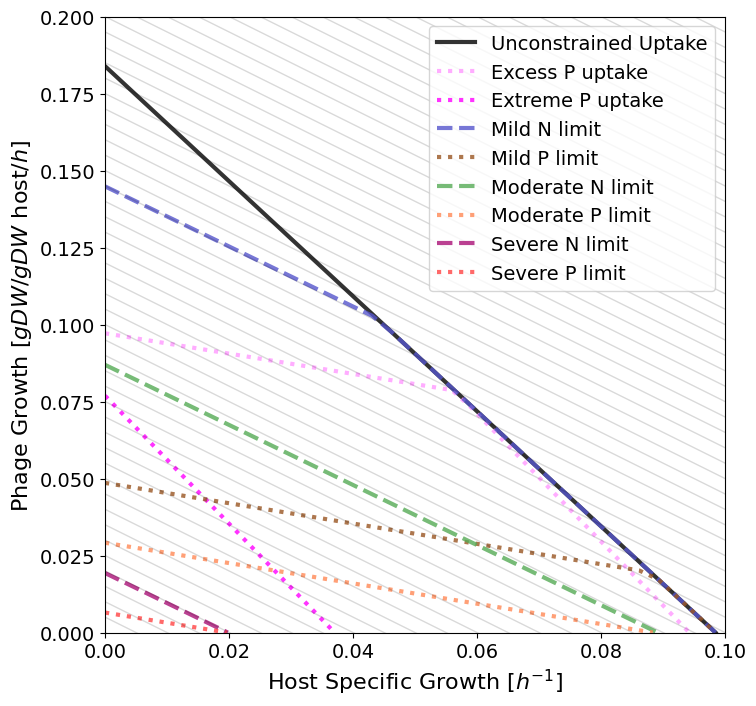

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
for scenario in scenarios:
    scenario_outputs[scenario].plot(
        x="host biomass",
        y="phage biomass max",
        ax=ax,
        label=scenario,
        color=scenario_colors[scenario],
        linewidth=3,
        alpha=0.8,
        linestyle="dashed"
        if "N" in scenario
        else "dotted"
        if "P" in scenario
        else "solid",
    )
for m in np.linspace(0.0, 0.4, 81):
    ax.plot(host_optimum_frac, m - host_optimum_frac, "k-", linewidth=1, alpha=0.15)
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.2)
ax.set_xlabel(r"Host Specific Growth $[h^{-1}]$", fontsize=16)
ax.set_ylabel(r"Phage Growth $[gDW /gDW$ host$ / h]$", fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=14)
plt.show()

In [25]:
np.linspace(0.025, 2.0, 8)

array([0.025     , 0.30714286, 0.58928571, 0.87142857, 1.15357143,
       1.43571429, 1.71785714, 2.        ])


 R00311 raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R05817 raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R05818 raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 PSIIabs raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R01063 absolute decrease 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R01523 absolute decrease 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild 

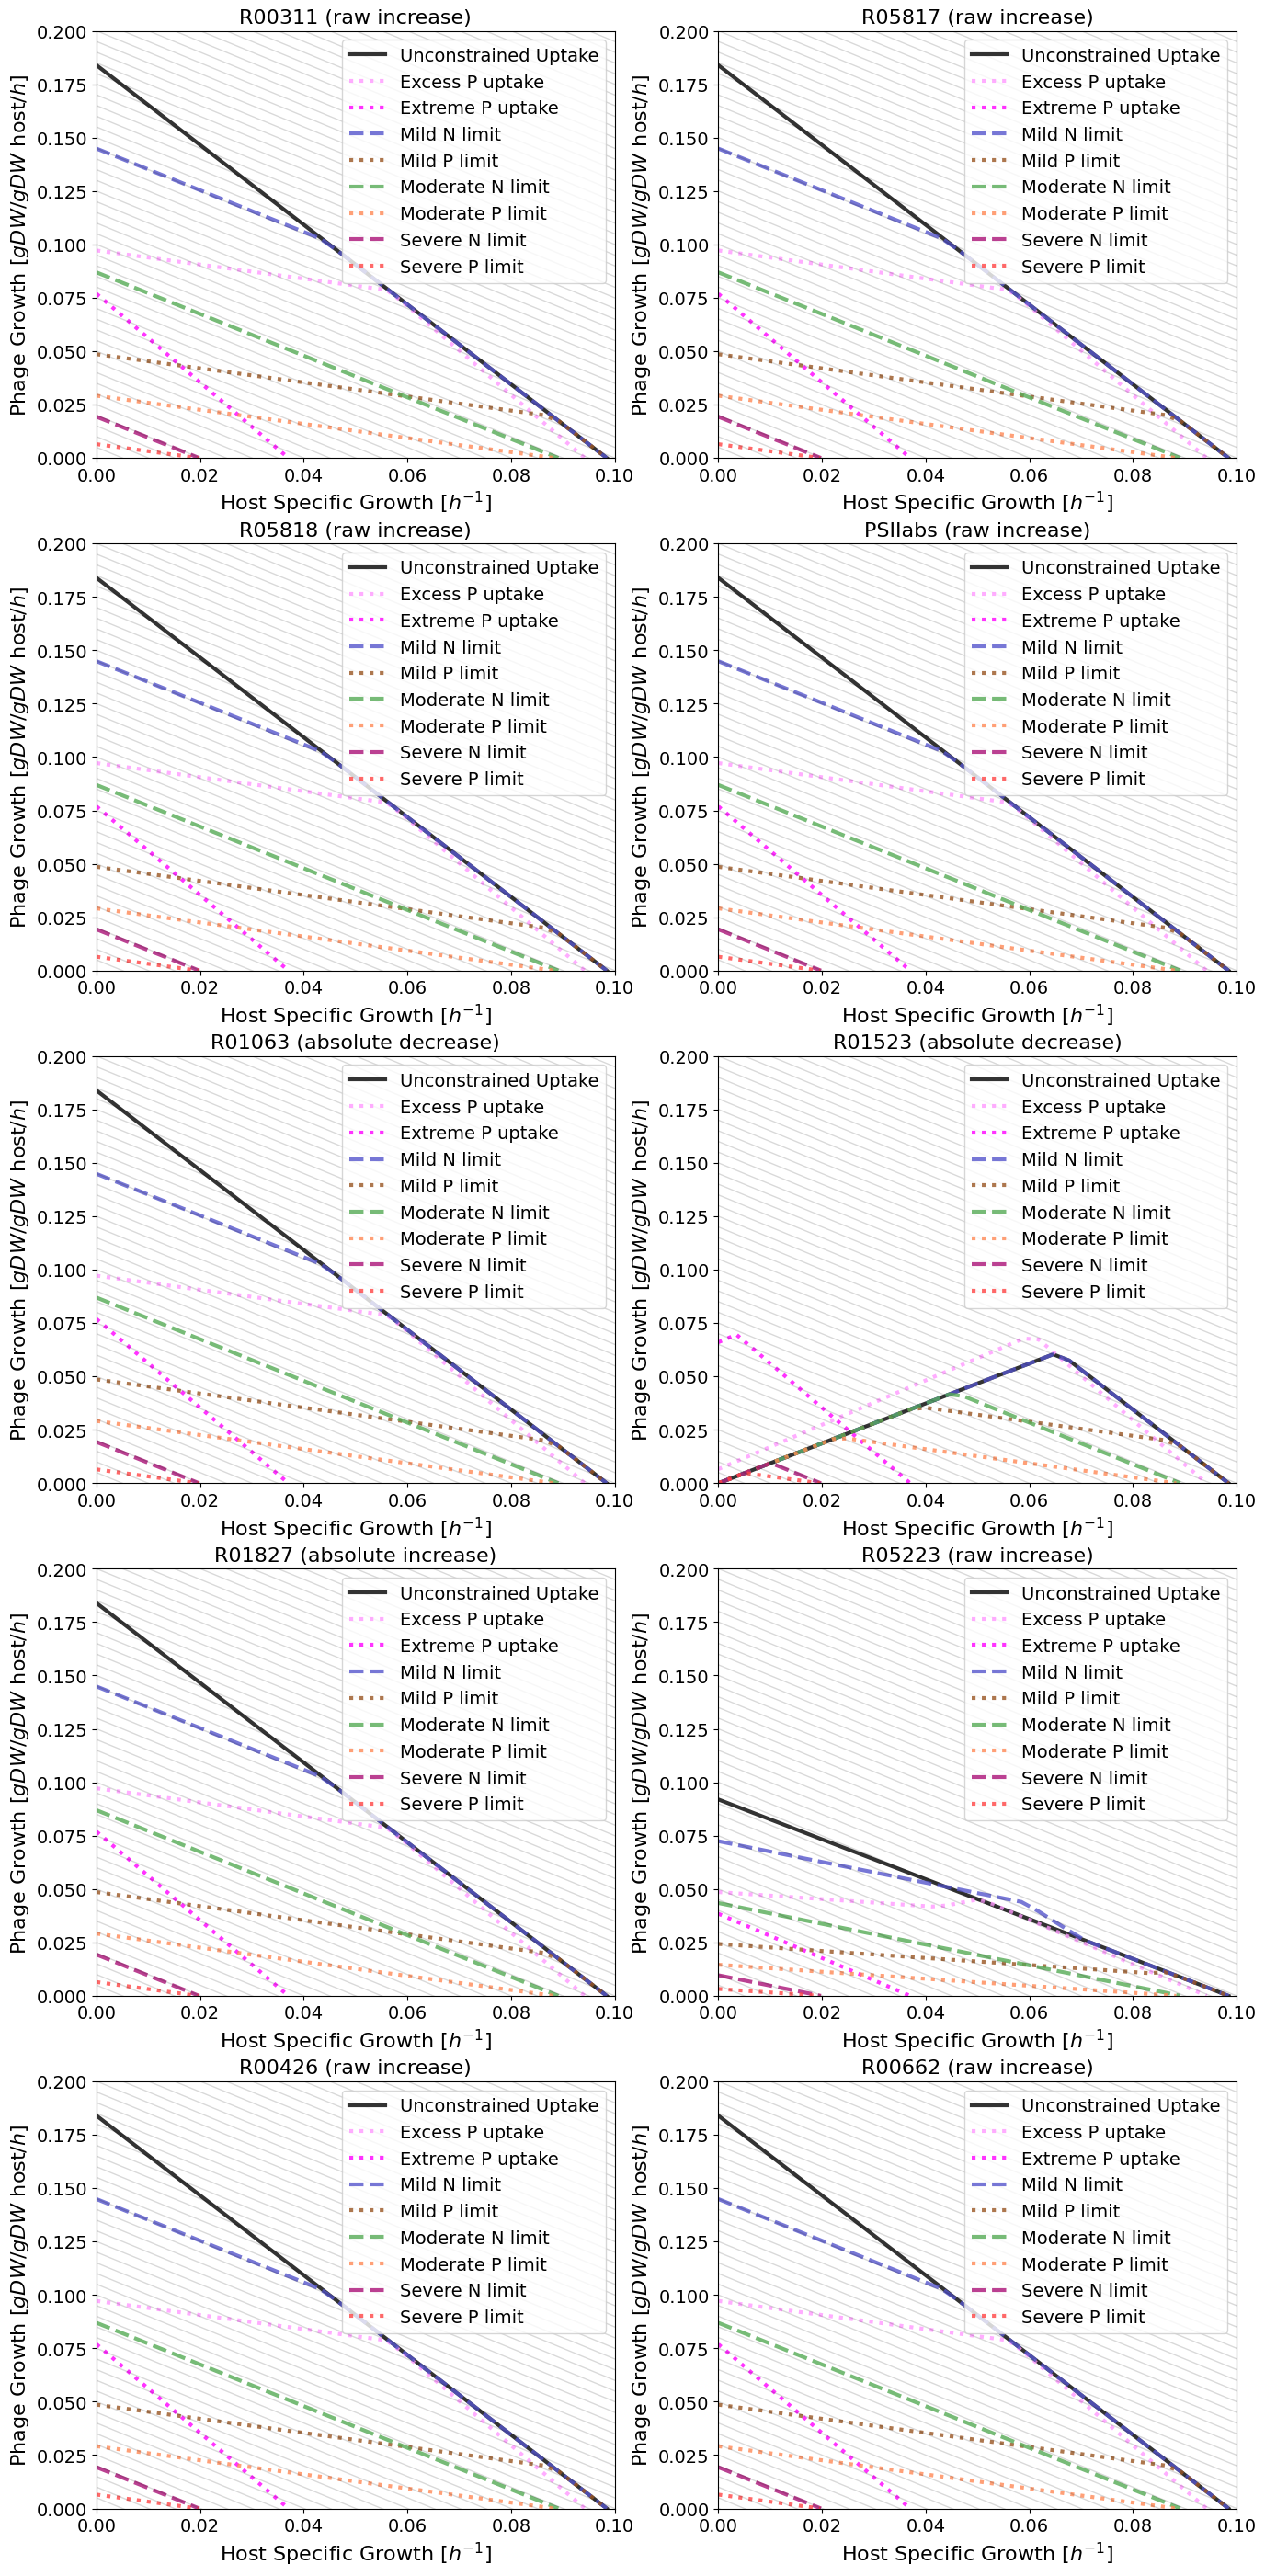

In [168]:
fig, axs = plt.subplots(5, 2, figsize=(16, 35))
amg_noP = {k: v for k, v in amgs.items() if k != "FAKEOrthophosphateEX"}
for (amg, direction), ax in zip(amg_noP.items(), axs.flatten()):
    print("\n", amg, direction, "\n", "-" * 10)
    scenario_outputs = {}
    for scenario in scenarios:
        print(scenario)
        host_biomass_frac = []
        phage_biomass_min_frac = []
        phage_biomass_max_frac = []
        for frac in host_optimum_frac:
            # for frac in np.linspace(0, 1, 5):
            with model as host_model:
                set_nutrient_limits(host_model, scenario)

                # get a baseline biomass in these nutrient conditions, and take
                # a fraction of that
                host_model.objective = host_model.reactions.BIOMASS.flux_expression
                host_optimum = host_model.slim_optimize()
                host_bio = host_optimum * frac
                host_biomass_frac.append(host_bio)

                # Find the biggest AMG impact consistent with that biomass fraction.
                # We allow some wiggle room here; about 10% of AMG rxn flux.
                host_model.reactions.BIOMASS.bounds = host_bio, host_bio
                set_amg_limits(host_model, amg, direction, tol=0.5)

                # Now, with AMG and biomass fixed, compute the optimal phage
                # biomass
                host_model.objective = (
                    host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_biomass_max_frac.append(host_model.slim_optimize())
        med4_opt = pd.DataFrame(
            np.array([host_biomass_frac, phage_biomass_max_frac]).T,
            columns=["host biomass", "phage biomass max"],
            dtype="float",
        )
        scenario_outputs[scenario] = med4_opt.map(
            lambda x: x if np.abs(x) > 1e-10 else 0
        )

    for scenario in scenarios:
        scenario_outputs[scenario].plot(
            x="host biomass",
            y="phage biomass max",
            ax=ax,
            label=scenario,
            color=scenario_colors[scenario],
            linewidth=3,
            alpha=0.8,
            linestyle="dashed"
            if "N" in scenario
            else "dotted"
            if "P" in scenario
            else "solid",
        )
    for m in np.linspace(0.0, 0.4, 81):
        ax.plot(host_optimum_frac, m - host_optimum_frac, "k-", linewidth=1, alpha=0.15)
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 0.2)
    ax.set_xlabel(r"Host Specific Growth $[h^{-1}]$", fontsize=16)
    ax.set_ylabel(r"Phage Growth $[gDW /gDW$ host$ / h]$", fontsize=16)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14, loc="upper right")
    ax.set_title(f"{amg} ({direction})", fontsize=16)
plt.show()

100%|██████████| 9/9 [00:00<00:00, 13.26it/s]


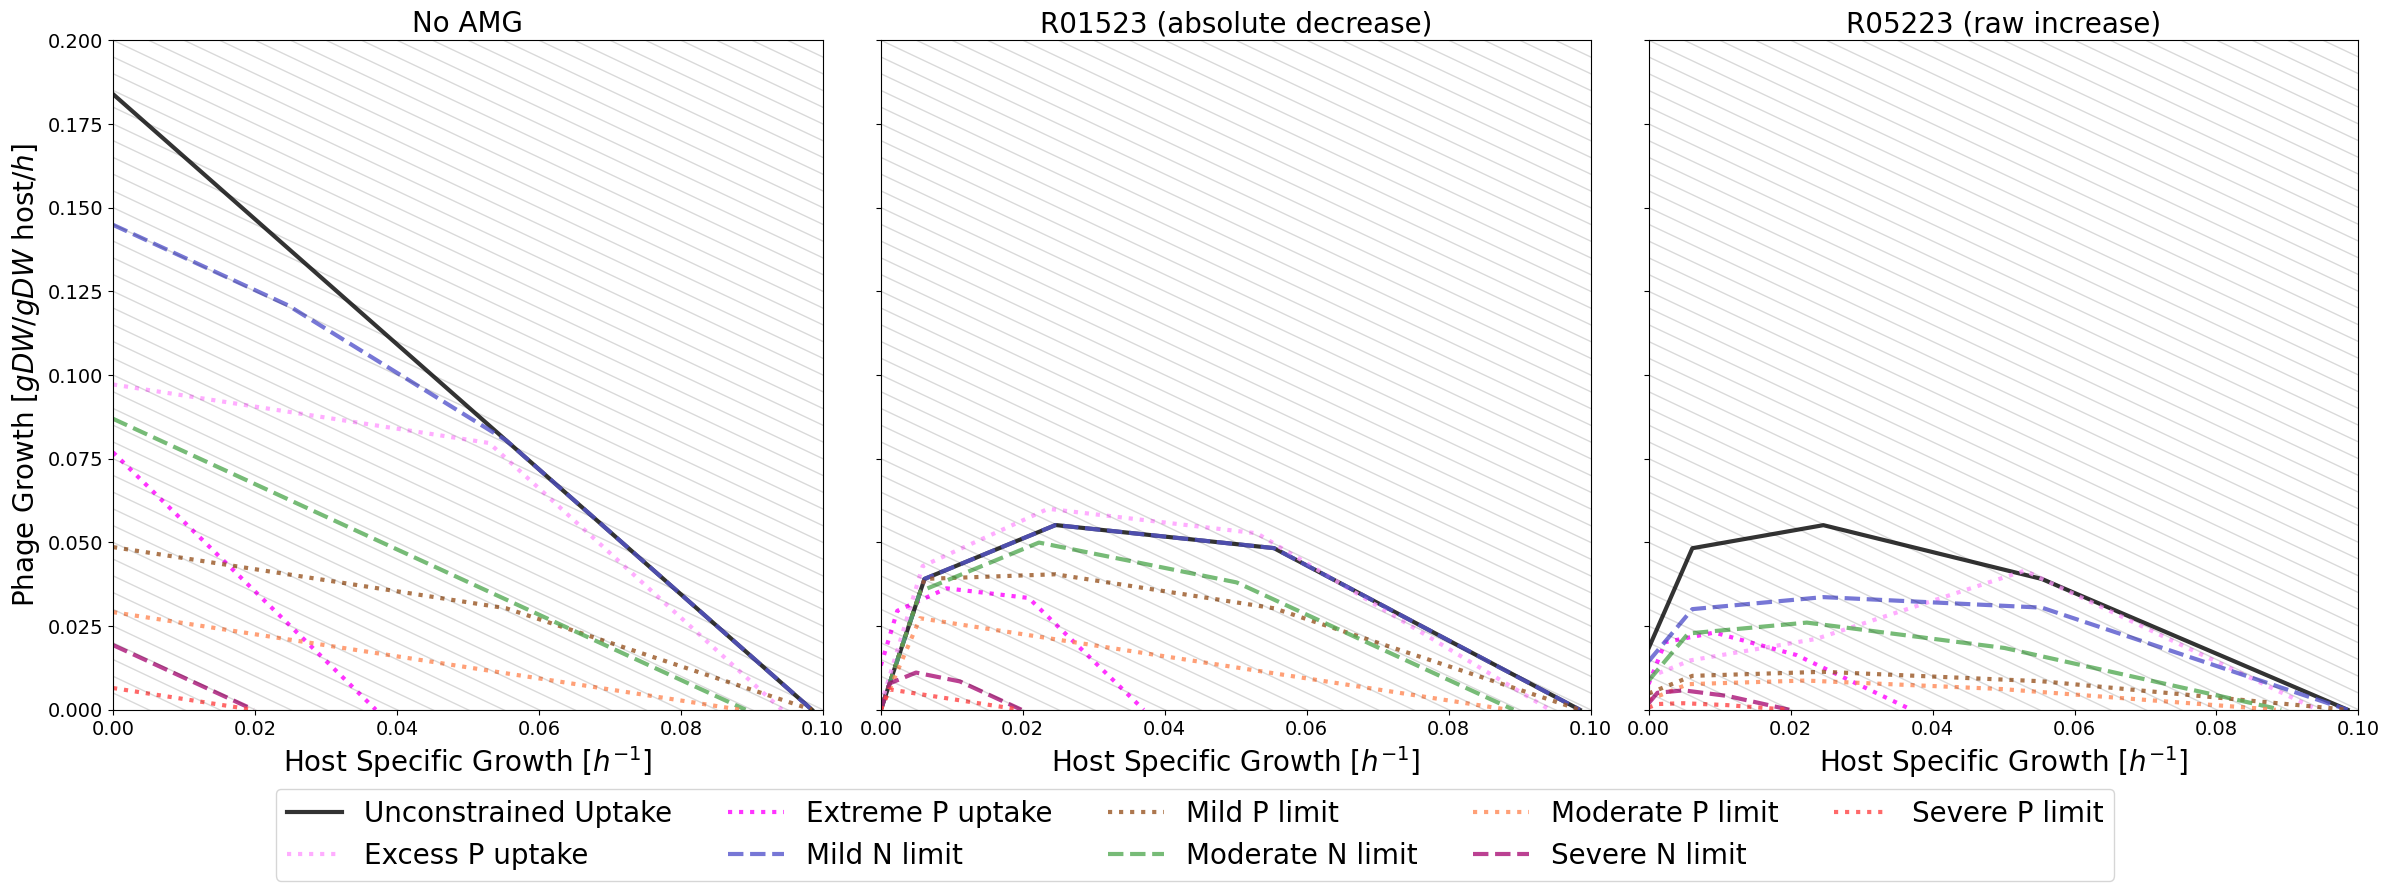

In [53]:
amgs_example = {
    "No AMG": "",
    "R01523": "absolute decrease",
    "R05223": "raw increase",
}
fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
for (amg, direction), ax in zip(amgs_example.items(), axs.flatten()):
    scenario_outputs = {}
    for scenario in tqdm(scenarios):
        host_biomass_frac = []
        phage_biomass_min_frac = []
        phage_biomass_max_frac = []
        # for frac in host_optimum_frac:
        for frac in np.linspace(0, 1, 5):
            with model as host_model:
                if scenario == "Mild N limit":
                    host_model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[0], 0
                elif scenario == "Mild P limit":
                    host_model.reactions.FAKEOrthophosphateEX.bounds = (
                        P_LIMIT_VALS[0],
                        0,
                    )
                elif scenario == "Moderate N limit":
                    host_model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[1], 0
                elif scenario == "Moderate P limit":
                    host_model.reactions.FAKEOrthophosphateEX.bounds = (
                        P_LIMIT_VALS[1],
                        0,
                    )
                elif scenario == "Severe N limit":
                    host_model.reactions.AmmoniaEX.bounds = N_LIMIT_VALS[2], 0
                elif scenario == "Severe P limit":
                    host_model.reactions.FAKEOrthophosphateEX.bounds = (
                        P_LIMIT_VALS[2],
                        0,
                    )
                elif scenario == "Excess P uptake":
                    host_model.reactions.FAKEOrthophosphateEX.bounds = (
                        2 * P_LIMIT_VALS[0],  # approx 3x host-optimal
                        2 * P_LIMIT_VALS[0],
                    )
                elif scenario == "Extreme P uptake":
                    host_model.reactions.FAKEOrthophosphateEX.bounds = (
                        20 * P_LIMIT_VALS[0],  # approx 30x host-optimal
                        20 * P_LIMIT_VALS[0],
                    )

                host_optimum = host_model.slim_optimize()
                host_bio = host_optimum * frac
                host_model.reactions.BIOMASS.bounds = host_bio, host_bio
                if direction == "raw increase":
                    host_model.objective = host_model.reactions.get_by_id(
                        amg
                    ).flux_expression
                    obj = host_model.slim_optimize()
                    host_model.reactions.get_by_id(amg).bounds = obj * 0.9, obj * 1.1
                elif direction == "absolute increase":
                    host_model.objective = (
                        host_model.reactions.get_by_id(amg).forward_variable
                        + host_model.reactions.get_by_id(amg).reverse_variable
                    )
                    obj = host_model.slim_optimize()
                    host_model.reactions.get_by_id(amg).bounds = (
                        -abs(obj) * 1.1,
                        abs(obj) * 1.1,
                    )
                elif direction == "absolute decrease":
                    host_model.objective = (
                        -host_model.reactions.get_by_id(amg).forward_variable
                        - host_model.reactions.get_by_id(amg).reverse_variable
                    )
                    obj = host_model.slim_optimize()
                    host_model.reactions.get_by_id(amg).bounds = (
                        -abs(obj) * 1.1,
                        abs(obj) * 1.1,
                    )

                host_model.objective = host_model.reactions.BIOMASS.flux_expression
                host_optimum = host_model.slim_optimize()

                host_bio = host_optimum * frac
                host_biomass_frac.append(host_bio)
                host_model.reactions.BIOMASS.bounds = host_bio, host_bio
                host_model.objective = (
                    host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_biomass_max_frac.append(host_model.slim_optimize())

                host_model.objective = (
                    -host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_biomass_min_frac.append(-host_model.slim_optimize())

        med4_opt = pd.DataFrame(
            np.array(
                [host_biomass_frac, phage_biomass_min_frac, phage_biomass_max_frac]
            ).T,
            columns=["host biomass", "phage biomass min", "phage biomass max"],
            dtype="float",
        )

        scenario_outputs[scenario] = med4_opt.map(
            lambda x: x if np.abs(x) > 1e-10 else 0
        )

    for scenario in scenarios:
        scenario_outputs[scenario].plot(
            x="host biomass",
            y="phage biomass max",
            ax=ax,
            label=scenario,
            color=scenario_colors[scenario],
            linewidth=3,
            alpha=0.8,
            linestyle="dashed"
            if "N" in scenario
            else "dotted"
            if "P" in scenario
            else "solid",
        )
    for m in np.linspace(0.0, 0.4, 81):
        ax.plot(host_optimum_frac, m - host_optimum_frac, "k-", linewidth=1, alpha=0.15)
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 0.2)
    ax.set_xlabel(r"Host Specific Growth $[h^{-1}]$", fontsize=20)
    ax.set_ylabel(r"Phage Growth $[gDW /gDW$ host$ / h]$", fontsize=20)
    ax.tick_params(labelsize=14)
    ax.legend().remove()
    if direction:
        ax.set_title(f"{amg} ({direction})", fontsize=20)
    else:
        ax.set_title(amg, fontsize=20)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label, fontsize=20, ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.125)
)
fig.tight_layout()
plt.show()


 R00311 raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R05817 raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R05818 raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 PSIIabs raw increase 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R01063 absolute decrease 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild N limit
Mild P limit
Moderate N limit
Moderate P limit
Severe N limit
Severe P limit

 R01523 absolute decrease 
 ----------
Unconstrained Uptake
Excess P uptake
Extreme P uptake
Mild 

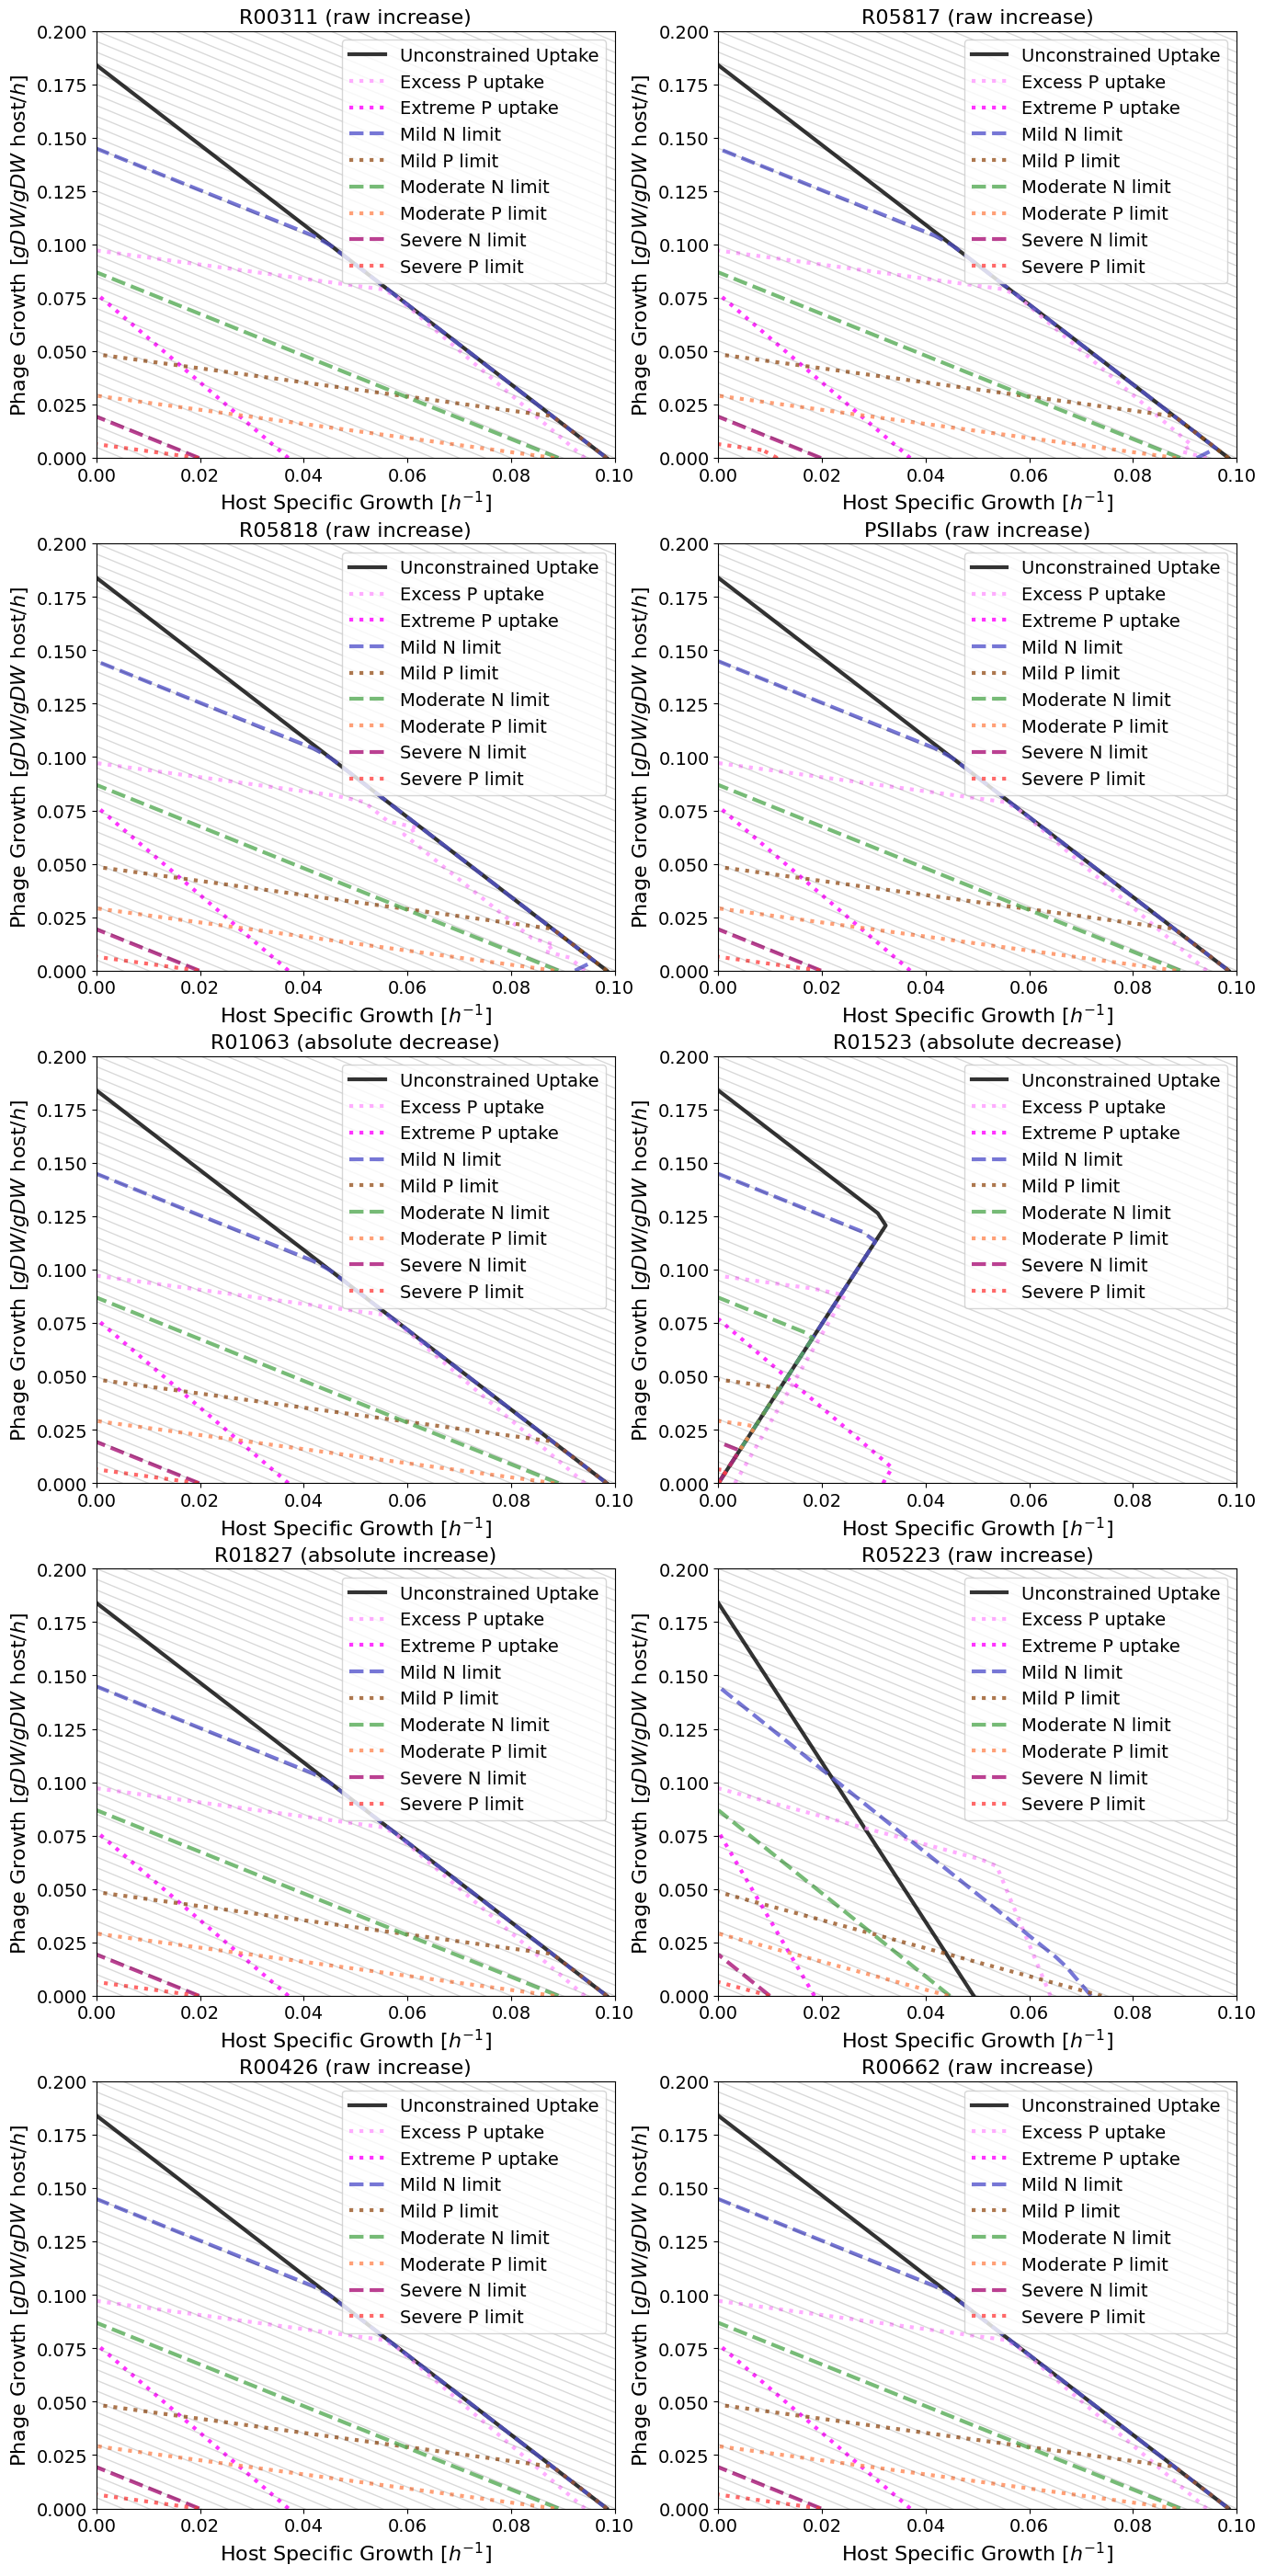

In [169]:
fig, axs = plt.subplots(5, 2, figsize=(16, 35))
amg_noP = {k: v for k, v in amgs.items() if k != "FAKEOrthophosphateEX"}
for (amg, direction), ax in zip(amg_noP.items(), axs.flatten()):
    print("\n", amg, direction, "\n", "-" * 10)
    scenario_outputs = {}
    for scenario in scenarios:
        print(scenario)
        host_biomass_frac = []
        phage_biomass_min_frac = []
        phage_biomass_max_frac = []
        for frac in host_optimum_frac:
            # for frac in np.linspace(0, 1, 5):
            with model as host_model:
                set_nutrient_limits(host_model, scenario)

                # get a baseline biomass in these nutrient conditions, and take
                # a fraction of that
                host_model.objective = (
                    host_model.reactions.PHM2_prodrxn_VN.flux_expression
                )
                phage_optimum = host_model.slim_optimize()
                phage_bio = phage_optimum * frac
                phage_biomass_max_frac.append(phage_bio)

                # Find the biggest AMG impact consistent with that biomass fraction.
                # We allow some wiggle room here; about 10% of AMG rxn flux.
                host_model.reactions.PHM2_prodrxn_VN.bounds = phage_bio, phage_bio
                set_amg_limits(host_model, amg, direction, tol=0.5)

                # Now, with AMG and biomass fixed, compute the optimal phage
                # biomass
                host_model.objective = host_model.reactions.BIOMASS.flux_expression
                host_biomass_frac.append(host_model.slim_optimize())
        med4_opt = pd.DataFrame(
            np.array([host_biomass_frac, phage_biomass_max_frac]).T,
            columns=["host biomass", "phage biomass max"],
            dtype="float",
        )
        scenario_outputs[scenario] = med4_opt.map(
            lambda x: x if np.abs(x) > 1e-10 else 0
        )

    for scenario in scenarios:
        scenario_outputs[scenario].plot(
            x="host biomass",
            y="phage biomass max",
            ax=ax,
            label=scenario,
            color=scenario_colors[scenario],
            linewidth=3,
            alpha=0.8,
            linestyle="dashed"
            if "N" in scenario
            else "dotted"
            if "P" in scenario
            else "solid",
        )
    for m in np.linspace(0.0, 0.4, 81):
        ax.plot(host_optimum_frac, m - host_optimum_frac, "k-", linewidth=1, alpha=0.15)
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 0.2)
    ax.set_xlabel(r"Host Specific Growth $[h^{-1}]$", fontsize=16)
    ax.set_ylabel(r"Phage Growth $[gDW /gDW$ host$ / h]$", fontsize=16)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14, loc="upper right")
    ax.set_title(f"{amg} ({direction})", fontsize=16)
plt.show()